In [1]:
from openai import OpenAI
import pandas as pd
import json
import duckdb #used for some of the SQL code
from pydantic import BaseModel, Field 
from IPython.display import Markdown

from helper import get_openai_api_key

In [2]:
# initialize the OpenAI client
openai_api_key = get_openai_api_key()
client = OpenAI(api_key=openai_api_key)

MODEL = "gpt-4o-mini"

#Tool 1: Dataset Lookup

In [3]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [4]:
# prompt templete for sql generation

SQL_GENERATION_PROMPT=""""
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is : {prompt}

The availabe columns are: {columns}
The table name is: {table_name}
"""

In [5]:
def generate_sql_query(prompt:str,columns:list,table_name:str)->str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt,columns=columns,table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role":"user","content":formatted_prompt}],
    )

    return response.choices[0].message.content

In [6]:
def lookup_sales_data(prompt:str)->str:
    """Implemantaion of sales data lookup from parquet file using SQL"""
    try:
        table_name="sales" #table name

        #read the parquet file into a duckdb table
        df=pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        #generate sql code
        sql_query=generate_sql_query(prompt ,df.columns,table_name)

        #clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query=sql_query.replace("```sql" , "").replace("```" , "")

        # execute the query
        result = duckdb.sql(sql_query).df()
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"
    


In [7]:
#testing first tool
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")

print(example_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

#Tool 2 : Data analysis 

In [8]:
DATA_ANALYSIS_PROMPT = """
Analyse the following data:{data}
Your job is to answer the following question:{prompt}"""

In [9]:
def analyze_sales_data(prompt:str,data:str)->str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data,prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role":"user", "content":formatted_prompt}]
    )

    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

In [10]:
print(analyze_sales_data(prompt = "What trends do you see in this data",
                         data=example_data))

Analyzing the provided data reveals several trends and insights regarding sales at Store Number 1320 on November 1, 2021. Here are the key trends observed:

1. **Volume of Sales**: The data indicates a variety of quantities sold across different products, ranging from 1 to 5 per SKU (Stock Keeping Unit). The total quantity sold includes both single and multi-unit sales, with multiple products being sold in larger quantities, such as items sold in quantities of 3 (at SKUs like 6183750 and 6184100).

2. **Sales Value Diversity**: There is a wide range of total sale values for different SKUs, indicating that the pricing varies significantly across different products. The cheapest item was sold for $0.89 (SKU 6174250), while some products sold for much higher amounts (e.g., SKU 6176200 for $99.98). This suggests a diverse product mix, likely catering to different customer segments.

3. **Promotional Impact**: Most products listed in the dataset were not on promotion (On_Promo = 0); however

#Tool 3 : Data visualization

In [13]:
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data:{data}
The goal is to show:{visualization_goal}
"""

In [14]:
class VisualizationConfig(BaseModel):
    chart_type : str = Field (...,description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [16]:
def extract_chart_config(data:str, visualization_goal:str)-> str:
    """Generate chart visualization configuration
    
    Args:
        data:String containing the data to visualize
        visualization_goal:Description of what the visualization should show
    Returns:
        Dictionary containing line chart configuaration
    """
    formatted_prompt=CHART_CONFIGURATION_PROMPT.format(data=data,visualization_goal=visualization_goal)

    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role":"user" , "content":formatted_prompt}],
        response_format=VisualizationConfig
    )       
    try:
        #Extract axis and title info from response
        content = response.choices[0].message.content

        return{
            "chart_type":content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return{
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }


In [17]:
CREATE_CHART_PROMPT="""
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config:{config}
"""

In [18]:
def create_chart(config: dict)-> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role":"user" , "content":formatted_prompt}],
    )

    code = response.choices[0].message.content
    code = code.replace("```python","").replace("```","")
    code = code.strip()

    return code


In [19]:
def generate_visualization(data:str,visualization_goal:str)->str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data,visualization_goal)
    code = create_chart(config)
    return code


In [22]:
code = generate_visualization(example_data,"A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = """Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
1320,6173050,22875,2021-11-01,1,4.990000,0
1320,6174250,22875,2021-11-01,1,0.890000,0
1320,6176200,22975,2021-11-01,2,99.980003,0
1320,6176800,22800,2021-11-01,1,14.970000,0
1320,6177250,22975,2021-11-01,1,6.890000,0
1320,6177300,22800,2021-11-01,1,9.990000,0
1320,6177350,22800,2021-11-01,2,16.980000,0
1320,6177700,22875,2021-11-01,1,3.190000,0
1320,6178000,22875,2021-11-01,2,6.380000,0
1320,6178250,22800,2021-11-01,1,16.590000,0
1320,6179250,24400,2021-11-01,1,14.990000,0
1320,6179300,22800,2021-11-01,2,9.980000,0
1320,6179400,24400,2021-11-01,2,29.980000,0
1320,6179450,24400,2021-11-01,1,14.990000,0
1320,6179500,24400,2021-11-01,1,14.990000,0
1320,6179750,22800,2021-11-01,2,39.980000,0
1320,6180550,22975,2021-11-01,1,15.990000,0
1320,6182050,22975,2021-11-01,1,7.990000,0
1320,6183750,22850,2021-11-01,3,38.970001,

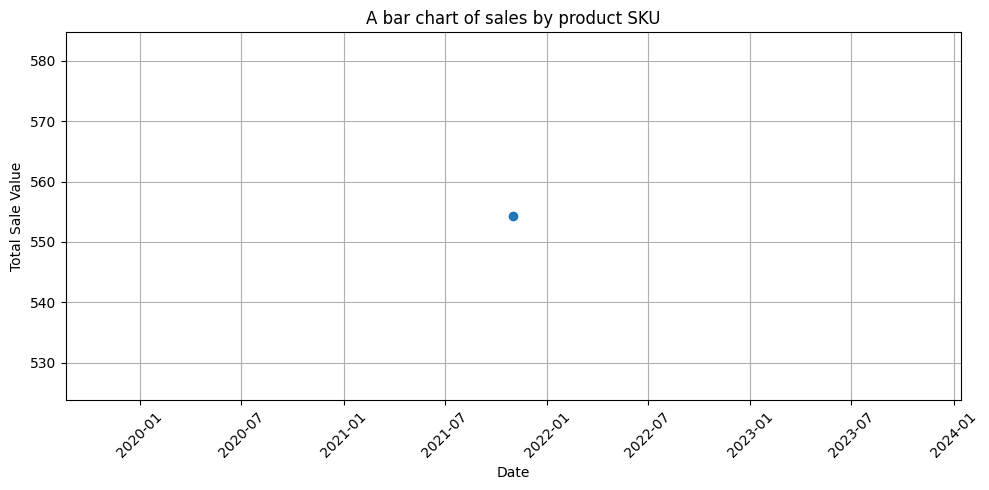

In [ ]:
exec(code)
# for safety we should wrap the code generated by llm within an enclosed environment 

# Defining the Router

In [24]:
#Tool Schema
tools =[{
    "type":"function",
    "function":{
        "name":"lookup_sales_data",
        "description":"Look up data from Store Scales Price Elasticity Promotions dataset",
        "parameters":{
            "type":"object",
            "properties":{
                "prompt":{"type":"string" , "description":"The unchanged prompt that the user provided."}  
            },
            "required":["prompt"]
        }
    }
},
{
    "type": "function",
    "function": {
        "name": "analyze_sales_data", 
        "description": "Analyze sales data to extract insights",
        "parameters": {
            "type": "object",
            "properties": {
                "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
            },
            "required": ["data", "prompt"]
        }
    }

},
{
    "type": "function",
    "function": {
        "name": "generate_visualization",
        "description": "Generate Python code to create data visualizations",
        "parameters": {
            "type": "object", 
            "properties": {
                "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
            },
            "required": ["data", "visualization_goal"]
        }
    }
}]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

#Router Logic

In [25]:
def handle_tool_calls(tool_calls,messages):
    
    for tool_call in tool_calls:
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role":"tool" , "content": result,"tool_call_id":tool_call.id})

    return messages


In [26]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [27]:
def run_agent(messages):
    print("Running agent with messages:",messages)

    if isinstance(messages,str):
        messages=[{"role":"user" , "content":messages}]

    if not any(
            isinstance(message , dict) and message.get("role") =="system" for message in messages
        ):
            system_prompt = {"role":"system","content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response=client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls= response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content
        
                

In [28]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [29]:
print(result)

Here is the Python code to create a line graph of sales by store for November 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Configuration
config = {
    'chart_type': 'line',
    'x_axis': 'date',
    'y_axis': 'value',
    'title': 'Create a graph of sales by store for November 2021.',
    'data': 'Store_Number  Total_Qty_Sold  Total_Sale_Value\n0            880          1525.0      17753.769956\n1           4180           913.0      10213.819920\n2            550           764.0       9554.049975\n3           1650          1770.0      23186.909958\n4           2420          1370.0      15234.709888\n5            660          1208.0      13041.239901\n6            770           973.0       9181.769959\n7           2640          1005.0      10891.639931\n8           2090          1080.0      11617.179888\n9           4840          1612.0      19127.169971\n10          3080          1454.0      18044.450005\n11          1320          170